See how the chip lists differs between newer (Nside 1024) vs. the reformatted file.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import pickle
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()

In [2]:
savedData= {}
filenames= ['2017-04-10_reformatted_nopixNum_chipPerVisitData_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nside1024_192103NonWFChipsToSimulate.pickle']
for filename in filenames:
    key= 'Reformatted_nside1024_new'
    with open('chipsPerVisitData/'+filename, 'rb') as handle:
        savedData[key]= pickle.load(handle)
        
filenames= ['2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside1024_192103NonWFChipsToSimulate.pickle']
for filename in filenames:
    key= 'nside1024_new'
    with open('chipsPerVisitData/'+filename, 'rb') as handle:
        savedData[key]= pickle.load(handle)

All detectors include:
- 8 non-science sensors: 'R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,4 S:1,0', 'R:0,4 S:2,1', 'R:4,0 S:0,1', 'R:4,0 S:1,2', 'R:4,4 S:0,1', 'R:4,4 S:1,0'
- 16 wavefront sensors: 'R:4,0 S:0,2,A', 'R:4,0 S:0,2,B','R:0,4 S:2,0,A', 'R:0,4 S:2,0,B', 'R:0,0 S:2,2,A', 'R:0,0 S:2,2,B', 'R:4,4 S:0,0,A', 'R:4,4 S:0,0,B'
           
           
^ which we are not simulating.

In [3]:
wavefront= ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B','R:0,4 S:2,0,A', 'R:0,4 S:2,0,B',
           'R:0,0 S:2,2,A', 'R:0,0 S:2,2,B','R:4,4 S:0,0,A', 'R:4,4 S:0,0,B']

nonScience= ['R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,4 S:1,0', 'R:0,4 S:2,1', 
             'R:4,0 S:0,1', 'R:4,0 S:1,2', 'R:4,4 S:0,1', 'R:4,4 S:1,0']

In [4]:
from intermediates import getSimData

In [5]:
# read in simdata
path= '/Volumes/Transcend/'
dbpath = path+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID', 'ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', newAfterburner= True, extraCols= extraCols)

In [6]:
oldData= 'nside1024_new'
newData= 'Reformatted_nside1024_new'

hIDs= []
missingList= []
missingCount= []
extraChipsList= []
extraChipsCounts= []
for hID in np.unique(simdata['obsHistID']):  # visit id in the new pickle
    i= np.where(savedData[newData]['obsHistID']==hID)[0]
    k= np.where(savedData[oldData]['obsHistID']==hID)[0]
    
    if (len(i)>0): # visit in the new list
        allNewChips= savedData[newData]['chipNames'][i]
        nonWFNewChips= list(set(allNewChips)-set(wavefront))
        goodNewChips= list(set(nonWFNewChips)-set(nonScience))
        if (len(k)>0): # visit was detected before
            allOldChips= savedData[oldData]['chipNames'][k]
            nonWFOldChips= list(set(allOldChips)-set(wavefront))
            goodOldChips= list(set(nonWFOldChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))
        else: # visit was never detected
            missingChips= goodNewChips
            extraChips= []
        
        hIDs.append(hID)
        missingList.append(missingChips)
        missingCount.append(len(missingChips))

        extraChipsList.append(extraChips)
        extraChipsCounts.append(len(extraChips))
        
    elif (len(k)>0):  # visit in the previous list but not in new 
        allOldChips= savedData[oldData]['chipNames'][k]
        nonWFOldChips= list(set(allOldChips)-set(wavefront))
        goodOldChips= list(set(nonWFOldChips)-set(nonScience))
        
        if (len(i)>0): # visit in the new list
            allNewChips= savedData[newData]['chipNames'][i]
            nonWFNewChips= list(set(allNewChips)-set(wavefront))
            goodNewChips= list(set(nonWFNewChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))

        else: # visit was never detected
            missingChips= []
            extraChips= goodOldChips
        hIDs.append(hID)
        missingList.append(missingChips)
        missingCount.append(len(missingChips)) 
        extraChipsList.append(extraChips)
        extraChipsCounts.append(len(extraChips))

/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


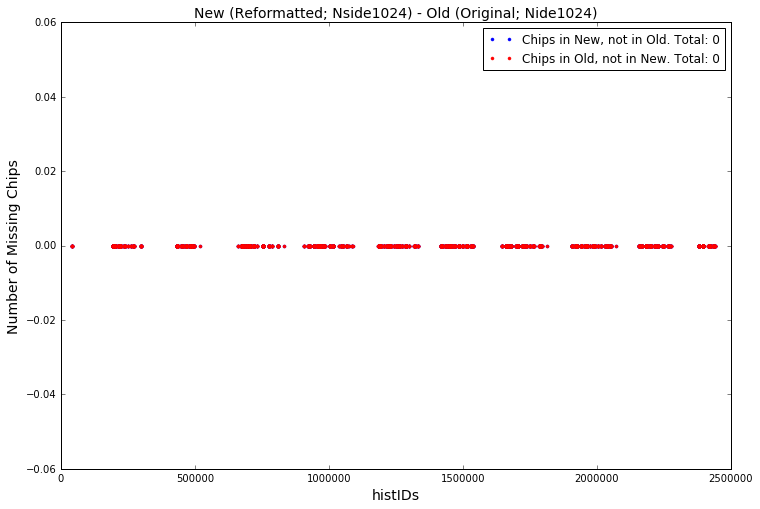

In [7]:
plt.plot(hIDs, missingCount, '.', color= 'b', label= 'Chips in New, not in Old. Total: %s'%(sum(missingCount)))
plt.plot(hIDs, -np.array(extraChipsCounts), '.', color= 'r', 
            label= 'Chips in Old, not in New. Total: %s'%(sum(extraChipsCounts)))
plt.legend()
plt.xlabel('histIDs', fontsize= 14)
plt.ylabel('Number of Missing Chips', fontsize= 14)
plt.title('New (Reformatted; Nside1024) - Old (Original; Nide1024)', fontsize= 14)

fig= plt.gcf()
fig.set_size_inches(12,8)
plt.show()

#### ^ Good: do not expect the two files to contain different non-null visits.